## BP 2004 model 

Billette, F. J., & Brandsberg-Dahl, S. (2005, June). The 2004 BP velocity benchmark. In 67th EAGE Conference & Exhibition (pp. cp-1). European Association of Geoscientists & Engineers.

The raw data can be downloaded from [this website](https://wiki.seg.org/wiki/2004_BP_velocity_estimation_benchmark_model#Madagascar_processing_scripts%7C)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp2d
import scipy.signal
import scipy.io
import obspy
import os
import seaborn as sns
sns.set_theme()

In [2]:
in_dir = "./models_raw/"
out_dir = "./models"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [3]:
def calc_dx_dt(f0, v):
    dx = v * 1/f0 / 10
    dy = dx
    dt = dx / v / 3
    return dx, dt

In [4]:
def ricker(f, dt):
    # nt = np.around(10/f/dt)
    # src = scipy.signal.ricker(nt, a=1/f0/dt)
    T = np.sqrt(20) / (np.pi * f)
    t = np.arange(-T, T, dt) 
    src = (1-2*np.pi**2*f**2*t**2)*np.exp(-np.pi**2*f**2*t**2) * 1e4
    return src

In [5]:
def extract_data(meta):
    data = []
    for trace in meta:
        data.append(trace.data)
    return np.array(data)

In [6]:
def load_BP_model():
    if not os.path.exists(os.path.join(in_dir, "vel_z6.25m_x12.5m_exact.segy.gz")):
        os.system("wget {} -P {}".format("http://s3.amazonaws.com/open.source.geoscience/open_data/bpvelanal2004/vel_z6.25m_x12.5m_exact.segy.gz", in_dir))

    meta = obspy.read(os.path.join(in_dir, "vel_z6.25m_x12.5m_exact.segy.gz"), format='segy')
    vp = extract_data(meta) * 1e3 #m/s^2
    
    nx, ny = vp.shape
    dx = 12.5 
    dy = 6.25
    x = np.arange(nx) * dx
    y = np.arange(ny) * dy

    model = {"vp": vp/1e3, "x": x, "y":y, "dx":dx, "dy":dy, "nx":nx, "ny":ny}

    return model

BP_model = load_BP_model()

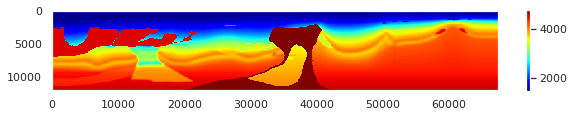

In [7]:
plt.figure(figsize=(10,5))
plt.pcolormesh(BP_model["x"][::10], BP_model["y"][::10], BP_model["vp"][::10,::10].T, shading='auto', cmap="jet")
plt.axis("scaled")
plt.gca().invert_yaxis()
plt.colorbar(shrink=0.3)
plt.show()

In [8]:
def resample_model(x, y, model):
    
    ratio_x = (x[1] - x[0])/(model['x'][1] - model['x'][0])
    ratio_y = (y[1] - y[0])/(model['y'][1] - model['y'][0])
    ratio = 3
    vp = gaussian_filter(model['vp'], [ratio_x/ratio, ratio_y/ratio], mode='reflect')
    
    vp = interp2d(model['y'], model['x'], vp, kind='linear')(y, x)
    
    new_model = {"vp":vp, "x":x, "y":y}
    new_model['dx'] = x[1] - x[0]
    new_model['dy'] = y[1] - y[0]
    
    return new_model

In [9]:
f0 = 1.5
vp0 = np.max(BP_model['vp'])
dx, dt = calc_dx_dt(f0*3, vp0)
dy = dx 
n_pml = 10
x_range = [0, 25000]
y_range = [0, 10000]
t_range = [0, np.sqrt((x_range[1] - x_range[0])**2 + (y_range[1] - y_range[0])**2)/np.mean(BP_model['vp']) * 1.5]
x = np.arange(x_range[0], x_range[1], dx)
y = np.arange(y_range[0], y_range[1], dy)
t = np.arange(t_range[0], t_range[1], dt)
nx = len(x)
ny = len(y)
nt = len(t)
src_rcv_depth = n_pml
mask_extra_detph = 2

print(f"nx = {nx}, ny = {ny}, nt = {nt}")
print(f"dx = {dx:.2f} m, dy = {dy:.2f} m, dt = {dt:.2e} s")

nx = 235, ny = 94, nt = 1531
dx = 106.44 m, dy = 106.44 m, dt = 7.41e-03 s


In [10]:
model = resample_model(x, y, BP_model)

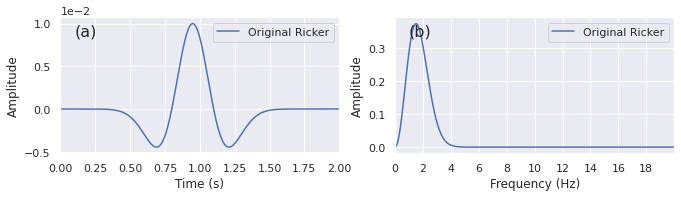

In [11]:
vec = np.zeros(nt)
vec_ricker = ricker(f0, dt)
# vec_ricker = gaussian(f0, dt)

vec[:len(vec_ricker)] = vec_ricker[:len(vec)]
t = np.arange(len(vec))*dt
f_vec = np.fft.fft(vec)
f = np.fft.fftfreq(len(vec), dt)

# sos = scipy.signal.butter(8, 6, "hp", fs=np.round(1/dt), output='sos')
# # sos = scipy.signal.cheby1(4, 0.1, 6, "hp", fs=np.round(1/dt), output='sos')
# filt_vec = scipy.signal.sosfilt(sos, vec)
# filt_vec = scipy.signal.sosfilt(sos, filt_vec[::-1])[::-1]

# filt_f_vec = np.fft.fft(filt_vec)
# filt_f = np.fft.fftfreq(len(filt_vec), dt)

plt.figure(figsize=(11,2.5))
plt.subplot(121)
plt.plot(t, vec/1e6, label="Original Ricker")
# plt.plot(t, filt_vec/1e6, "--", label="6Hz High-pass Filtering")
plt.xlim([0, 2.0])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc="upper right")
plt.gca().ticklabel_format(axis="y",style="sci", scilimits=(0.0,0.0))
plt.text(0.05, 0.95, "(a)", horizontalalignment='left', verticalalignment='top', transform=plt.gca().transAxes, fontsize=16)
plt.subplot(122)
plt.plot(f[:len(f)//2], np.abs(f_vec)[:len(f)//2]/1e6, label="Original Ricker")
# plt.plot(f[:len(f)//2], np.abs(filt_f_vec)[:len(filt_f)//2]/1e6, "--", label="6Hz High-pass Filtering")
# plt.plot(plt.xlim(), [0, 0], '--')
plt.xlim([0, 20])
plt.xticks(range(0,18+1,2))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid("major")
plt.legend(loc="upper right")
plt.text(0.05, 0.95, "(b)", horizontalalignment='left', verticalalignment='top', transform=plt.gca().transAxes, fontsize=16)
# plt.savefig("source.png", bbox_inches="tight")
# plt.savefig("source.pdf", bbox_inches="tight")
plt.show()

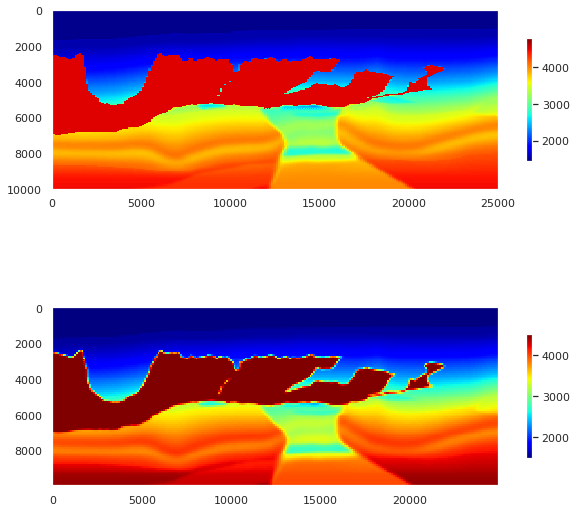

In [12]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.pcolormesh(BP_model["x"][::10], BP_model["y"][::10], BP_model["vp"][::10,::10].T, shading='auto', cmap="jet")
plt.axis("scaled")
plt.xlim(x_range)
plt.ylim(y_range)
plt.gca().invert_yaxis()
plt.colorbar(shrink=0.5)

plt.subplot(212)
plt.pcolormesh(model["x"], model["y"], model["vp"].T, shading='auto', cmap="jet")
plt.axis("scaled")
plt.gca().invert_yaxis()
plt.colorbar(shrink=0.5)
plt.show()

In [13]:
def add_source(nsrc, nx, nt, dt, f0=5, n_pml=0):
    src_list = []
    src_ix = np.round(np.linspace(0+2*n_pml, nx-2*n_pml, nsrc)).astype('int')
    print(f"Number of sources: {len(src_ix)}; Interval between sources: {(src_ix[1]-src_ix[0])*dx:.1f} m")
    src_iy = np.ones_like(src_ix) * src_rcv_depth
    src_vec = np.zeros(nt)
    vec = ricker(f0, dt)
    src_vec[:len(vec)] = vec[:nt]
    for i in range(nsrc):
        tmp = {"ix": src_ix[i], "iy": src_iy[i], "type": 0, "vec": src_vec}
        src_list.append(tmp)
    return src_list

nsrc = 8
source_list = add_source(nsrc, nx, nt, dt, f0, n_pml)

Number of sources: 8; Interval between sources: 2980.4 m


In [14]:
def add_receiver(nrcv, nsrc, nx, n_pml=0, full=False):
    rcv = {}
    if full:
        rcv['ix'] = np.arange(n_pml, nx-n_pml+1).astype('int')
    else:
        rcv['ix'] = np.round(np.linspace(0+n_pml, nx-n_pml, nrcv)).astype('int')
    rcv['iy'] = np.ones_like(rcv['ix']) * src_rcv_depth
    rcv['type'] = np.zeros_like(rcv['ix'])
    print(f"Number of receivers: {len(rcv['ix'])}; Interval of receivers: {(rcv['ix'][1]-rcv['ix'][0])*dx:.1f} m")

    rcv_list = [rcv] * nsrc
    
    return rcv_list

nrcv = int(nx*dx / (int(vp0/f0)/6))
receiver_list = add_receiver(nrcv, nsrc, nx, n_pml, False)

Number of receivers: 47; Interval of receivers: 532.2 m


In [15]:
def get_smooth_model(model, src):
    if mask_extra_detph > 0:
        vp = model['vp'].copy()
        vp[:,src_rcv_depth+mask_extra_detph:] = gaussian_filter(model['vp'][:, src_rcv_depth+mask_extra_detph:], [10,10], mode='reflect')
    else:
        vp = model['vp'].copy()
        vp = gaussian_filter(model['vp'], [5,5], mode='reflect')
    
    vp = np.mean(vp, axis=0, keepdims=True).repeat(nx, axis=0)
    
    mask = np.ones_like(vp)
    if mask_extra_detph > 0:
        mask[:,:src_rcv_depth+mask_extra_detph]=0
        vp[:,:src_rcv_depth+mask_extra_detph] = model['vp'][:,:src_rcv_depth+mask_extra_detph]
    
    new_model = {"vp":vp, "x":x, "y":y, "dx":dx, "dy":dy, "mask":mask}

    return new_model

smooth_model = get_smooth_model(model, source_list[0])

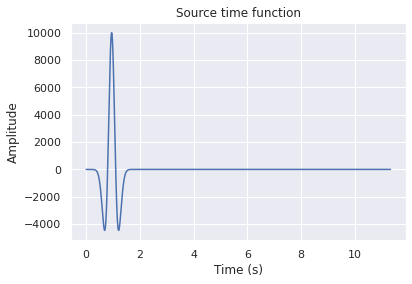

In [16]:
plt.figure()
plt.plot(t, source_list[0]['vec'])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title("Source time function")
plt.show()

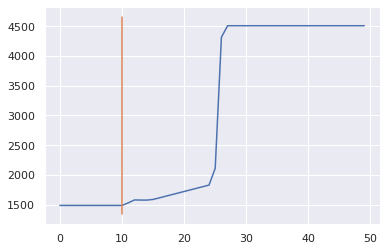

In [17]:
plt.figure()
plt.plot(model['vp'][nx//2,:50])
plt.plot([src_rcv_depth, src_rcv_depth], plt.ylim())

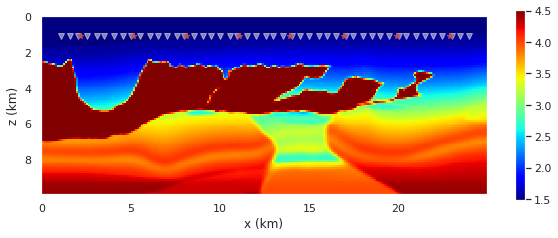

In [18]:
plt.figure(figsize=(10,7))
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]/1e3
plt.pcolormesh(x_mesh/1e3-x0, y_mesh/1e3, model['vp'].T/1e3, shading='auto', cmap="jet")
plt.plot(x[receiver_list[0]['ix']]/1e3-x0, y[receiver_list[0]['iy']]/1e3, 'wv', alpha=0.5)
for i in range(len(source_list)):
    plt.plot(x[source_list[i]['ix']]/1e3-x0, y[source_list[i]['iy']]/1e3, 'r*')
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(out_dir, "BP-model-vp.png"))
plt.show()

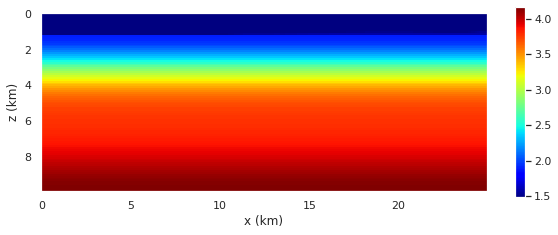

In [19]:
plt.figure(figsize=(10,7))
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]/1e3
plt.pcolormesh(x_mesh/1e3-x0, y_mesh/1e3, smooth_model['vp'].T/1e3, shading='auto', cmap="jet")
# plt.plot(x[receiver_list[0]['ix']]/1e3-x0, y[receiver_list[0]['iy']]/1e3, 'wv', alpha=0.5)
# for i in range(len(source_list)):
#     plt.plot(x[source_list[i]['ix']]/1e3-x0, y[source_list[i]['iy']]/1e3, 'r*')
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(out_dir, "BP-model-smooth-vp.png"))
plt.show()

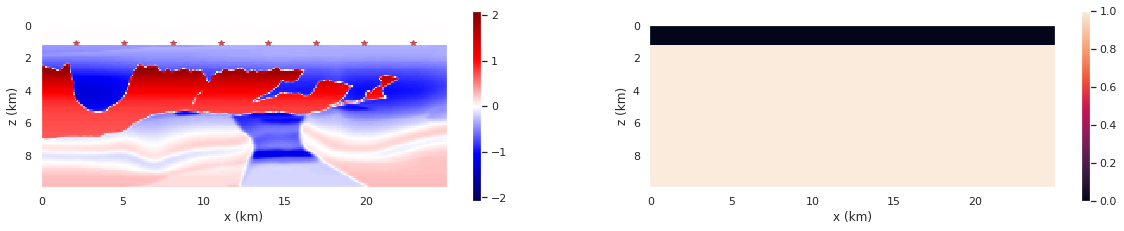

In [20]:
plt.figure(figsize=(20,7))
plt.subplot(121)
x_mesh, y_mesh = np.meshgrid(x, y)
x0 = x[0]/1e3
vmax = np.max(np.abs((model['vp'] - smooth_model['vp']).T/1e3))
plt.pcolormesh(x_mesh/1e3-x0, y_mesh/1e3, (model['vp'] - smooth_model['vp']).T/1e3, cmap="seismic", vmax=vmax, vmin=-vmax, shading='auto')
# plt.plot(x[receiver_list[0]['ix']]/1e3-x0, y[receiver_list[0]['iy']]/1e3, 'wv', alpha=0.5)
for i in range(len(source_list)):
    plt.plot(x[source_list[i]['ix']]/1e3-x0, y[source_list[i]['iy']]/1e3, 'r*')
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.subplot(122)
plt.pcolormesh(x_mesh/1e3-x0, y_mesh/1e3, smooth_model["mask"].T, shading='auto')
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.colorbar(shrink=0.5)
plt.savefig(os.path.join(out_dir, "BP-model-diff-vp.png"))
plt.show()

In [21]:
scipy.io.savemat(os.path.join(out_dir, 'BP-model-true.mat'),
         {"vp" : model['vp'], 
         "source" : source_list,
         "receiver" : receiver_list,
         "dx" : dx,
         "dy" : dy,
         "dt" : dt,
         "nx" : nx,
         "ny" : ny,
         "nt" : nt,
         "f0" : f0})

In [22]:
scipy.io.savemat(os.path.join(out_dir, 'BP-model-smooth.mat'),
         {"vp" : smooth_model['vp'], 
          "mask": smooth_model["mask"],
         "source" : source_list,
         "receiver" : receiver_list,
         "dx" : dx,
         "dy" : dy,
         "dt" : dt,
         "nx" : nx,
         "ny" : ny,
         "nt" : nt,
         "f0" : f0})